In [2]:
import numpy as np
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper

from gym import wrappers


# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env(seed=None, monitor_directory=None):
    env_spec = gym.spec('ppaquette/DoomBasic-v0')
    env_spec.id = 'DoomBasic-v0'
    env = env_spec.make()

    if seed is not None:
        env.seed(seed)

    if monitor_directory is not None:
        env = wrappers.Monitor(env, monitor_directory, force=True, mode='training', 
                               video_callable=lambda episode_id: episode_id % 100 == 0)

    return SetResolution('200x150')(
        SkipWrapper(repeat_count=4)(
        ToDiscrete('minimal')(env)))
    #return SkipWrapper(repeat_count=4)(
    #    ToDiscrete('minimal')(env))

env = create_env()


NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3

(150, 200, 3)


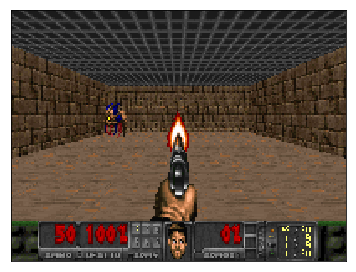

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.transform import resize
from skimage.color import rgb2gray

WIDTH, HEIGHT, CHANNELS = 200, 150, 1


def pre_process(obs, size=(HEIGHT, WIDTH)):
    #return resize(rgb2gray(obs), size).reshape((-1,) + size)
    #return rgb2gray(obs).reshape((-1,) + size)
    return obs
obs = env.reset()
obs, _, _, _ = env.step(action=1)

plt.figure(figsize=[6, 6])

print(obs.shape)
def show(observation):
    if CHANNELS == 1:
        plt.imshow(observation.squeeze(), interpolation=None, cmap='gray')
    else:
        plt.imshow(observation, interpolation=None)
    plt.xticks([]); plt.yticks([]);
    
show(obs)
env.close()

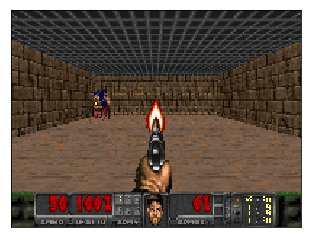

In [9]:
show(pre_process(obs))

## Deep Q-learning

 * https://github.com/coreylynch/async-rl/blob/master/model.py and https://github.com/tflearn/tflearn/blob/master/examples/reinforcement_learning/atari_1step_qlearning.py with 84 x 84 images

```
    net = tflearn.conv_2d(net, 32, 8, strides=4, activation='relu')
    net = tflearn.conv_2d(net, 64, 4, strides=2, activation='relu')
    net = tflearn.fully_connected(net, 256, activation='relu')
```

 * https://github.com/ebonyclock/deep_rl_vizdoom/blob/master/networks/common.py#L20 with 80 x 60 images
 
```
    conv1 = layers.conv2d(img_input, num_outputs=8, kernel_size=[6, 6], stride=3, padding="VALID", ...)
    conv2 = layers.conv2d(conv1, num_outputs=8, kernel_size=[3, 3], stride=2, padding="VALID", ...)

```
 * From http://vizdoom.cs.put.edu.pl/tutorial#learning with images (30, 45)!
```
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[6, 6], nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=3)
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[3, 3],nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=2)
dqn = DenseLayer(dqn, num_units=128, nonlinearity=rectify, W=HeUniform("relu"), b=Constant(.1))
```
 

In [14]:
import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Dense, Convolution2D, Flatten, Activation
from keras.models import Sequential, Model
from keras.optimizers import Adam

sess = tf.InteractiveSession()
K.set_session(sess)

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):
    model = Sequential()
    model.add(
        Convolution2D(nb_filter=2, nb_row=6, nb_col=6, subsample=(1, 1), border_mode='valid', weights=conv1_weights,
            input_shape=[HEIGHT, WIDTH, 3], dim_ordering='tf'))
    model.add(Activation('relu'))
    model.add(
        Convolution2D(nb_filter=4, nb_row=2, nb_col=2, subsample=(1, 1), weights=conv2_weights))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(64, init='normal', weights=dense1_weights))
    model.add(Activation('relu'))
    model.add(Dense(4, init='normal', weights=dense2_weights))
    model.compile(loss='mse', optimizer=Adam())
    
    return model

acting_model = create_q_model()
target_model = create_q_model()

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[0].weights]
    conv2_weights = [w.eval() for w in model.layers[2].weights]
    dense1_weights = [w.eval() for w in model.layers[5].weights]
    dense2_weights = [w.eval() for w in model.layers[7].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)

acting_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_381 (Convolution2D (None, 145, 195, 2)   218         convolution2d_input_191[0][0]    
____________________________________________________________________________________________________
activation_571 (Activation)      (None, 145, 195, 2)   0           convolution2d_381[0][0]          
____________________________________________________________________________________________________
convolution2d_382 (Convolution2D (None, 4, 194, 1)     2324        activation_571[0][0]             
____________________________________________________________________________________________________
activation_572 (Activation)      (None, 4, 194, 1)     0           convolution2d_382[0][0]          
___________________________________________________________________________________________

## Collecting and preparing experiences for learning

In [6]:
# from https://docs.python.org/3/library/itertools.html#recipes
from itertools import tee, zip_longest

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [11]:
from collections import namedtuple, deque
from itertools import islice 
import operator
import functools
import random


SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])
Experience = namedtuple('Experience', ['previous_state', 'action', 'reward', 'next_state', 'end'])


class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()

def generate_sares(env, agent, episode_count=2000):
    reward = 0
    done = False

    for i in range(episode_count):
        if (i % 10) == 0:
            print('episode {i}'.format(i=i))
        observation = pre_process(env.reset())
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            yield SARE(observation, action, reward, done)
            
            if done:
                break
            else:
                observation = pre_process(new_observation)


def to_experiences(sares):
    return (
        Experience(previous_s, a, r, next_s, end) 
        for (previous_s, a, r, end), (next_s, _, _, _) 
        in pairwise(sares)
    )

import itertools as it

class ExperiencesReplay:
    def __init__(self, experiences_iterable, memory_size=1000, batch_size=32, replay_ratio=.25):
        self.experiences_iterable = experiences_iterable
        self.batch_size = batch_size
        self.replay_ratio = replay_ratio
        self.memory = deque(maxlen=memory_size)

    def __iter__(self):
        return self

    def __next__(self):
        for exp in it.islice(self.experiences_iterable, int(self.replay_ratio * self.batch_size)):
            self.memory.appendleft(exp)
        
        experiences_batch = list(e for e in self.memory if e.reward > 0) \
            + random.choices(self.memory, k=self.batch_size)        
        random.shuffle(experiences_batch)

        return experiences_batch
    
env = create_env()


experiences = to_experiences(generate_sares(env, EpsilonGreedyQAgent(acting_model)))

streamlined_experience_batches = grouper(experiences, n=200)

print('streamlined_experience_batches')
print(len(list(next(streamlined_experience_batches))))

print('replayed_batches')
replayed_batches = ExperiencesReplay(experiences, memory_size=10)

print(len(next(replayed_batches)), len(replayed_batches.memory))
print(len(next(replayed_batches)), len(replayed_batches.memory))

episode 0
streamlined_experience_batches
200
replayed_batches
32 8
32 10


## Training

In [15]:
class DeepQNetworkTrainer:
    
    MINI_BATCH_SIZE = 128
    UPDATE_TARGET_EVERY_N_BACTHES = 2
    
    def __init__(self, acting_model, target_model, double_q=False, gamma=.99, reward_clip=5):
        self.acting_model = acting_model
        self.target_model = target_model
        self.double_q = double_q
        
        self.gamma = gamma
        self.reward_clip = reward_clip

        # counter to periodically set target_model <- acting_model
        self.trained_epochs = 0
    
    def fit_episodes(self, experiences_batch):
        prev_frames, target_action_rewards = self._batch_to_input_targets(experiences_batch, double_q=self.double_q)
        self.acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=self.MINI_BATCH_SIZE, nb_epoch=1, verbose=0)
        self.trained_epochs += 1

        if (self.trained_epochs % self.UPDATE_TARGET_EVERY_N_BACTHES) == 0:
            print('target_model <- acting_model')
            self.target_model = copy_model(self.acting_model)

    def _batch_to_input_targets(self, experiences_batch, double_q=False):
        
        prev_frames, actions, rewards, next_frames, is_ends = map(np.asarray, zip(*experiences_batch))
        n_samples = len(experiences_batch)
        print('Batch of {} exps with avg reward {} and dist. {} and actions distribution {}'.format(
            n_samples,
            np.mean(rewards),
            np.histogram(rewards, bins=3)[0].tolist(),
            np.bincount(actions).tolist()))

        clipped_rewards = np.clip(rewards, -np.inf, self.reward_clip)

        if double_q:
            greedy_actions = self.acting_model.predict(next_frames).argmax(axis=1)
            actions_target_values = self.target_model.predict(next_frames)[np.arange(n_samples), greedy_actions]            
            targets = clipped_rewards + self.gamma * (1 - is_ends) * actions_target_values
        else:
            # Transcription of the Q-learning target formula
            targets = clipped_rewards + self.gamma * (1 - is_ends) * self.target_model.predict(next_frames).max(axis=1)

        target_action_rewards = self.target_model.predict(prev_frames)
        target_action_rewards[np.arange(n_samples), actions] = targets
        return prev_frames, target_action_rewards
    
trainer = DeepQNetworkTrainer(acting_model, target_model)

In [16]:
import itertools as it

N_EPISODES = 1500

directory = 'tmp/DoomBasic_dqn_old'
env = create_env(monitor_directory=directory)

agent = EpsilonGreedyQAgent(acting_model, epsilon=.1)
experiences = to_experiences(generate_sares(env, agent, episode_count=N_EPISODES))
experience_batches = ExperiencesReplay(
    experiences,
    memory_size=1000, batch_size=DeepQNetworkTrainer.MINI_BATCH_SIZE)

for experience_batch in experience_batches:
    trainer.fit_episodes(experience_batch)

# final greedy episodes
sares = list(generate_sares(env, EpsilonGreedyQAgent(acting_model, epsilon=0), episode_count=100))

env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-12 23:28:06,555] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-12 23:28:06,557] Creating monitor directory tmp/DoomBasic_dqn_old


episode 0


[2017-03-12 23:28:07,188] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000000.mp4
Exception ignored in: <bound method Env.__del__ of <SetResolutionWrapper<SkipWrapper<ToDiscreteWrapper<_Monitor<TimeLimit<DoomBasicEnv instance>>>>>>>
Traceback (most recent call last):
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 346, in _close
    return self.env.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-pack

Batch of 128 exps with avg reward -6.796875 and dist. [46, 0, 82] and actions distribution [6, 118, 4]
Batch of 128 exps with avg reward -6.2890625 and dist. [33, 0, 95] and actions distribution [3, 92, 5, 28]
target_model <- acting_model
Batch of 128 exps with avg reward -6.5234375 and dist. [39, 0, 89] and actions distribution [7, 65, 6, 50]
Batch of 128 exps with avg reward -6.1328125 and dist. [29, 0, 99] and actions distribution [4, 56, 7, 61]
target_model <- acting_model
Batch of 128 exps with avg reward -5.703125 and dist. [18, 0, 110] and actions distribution [8, 43, 4, 73]
Batch of 128 exps with avg reward -5.7421875 and dist. [19, 0, 109] and actions distribution [1, 38, 6, 83]
target_model <- acting_model
Batch of 128 exps with avg reward -5.859375 and dist. [22, 0, 106] and actions distribution [6, 45, 5, 72]
Batch of 128 exps with avg reward -5.8203125 and dist. [21, 0, 107] and actions distribution [3, 30, 6, 89]
target_model <- acting_model
Batch of 129 exps with avg rew

  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 252, in __del__
    self.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/core.py", line 190, in close
    self._close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/wrappers/monitoring.py", line 38, in _close
    self._monitor.close()
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/monitoring/monitor_manager.py", line 193, in close
    self._flush(force=True)
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/monitoring/monitor_manager.py", line 183, in _flush
    'env_info': self._env_info(),
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/monitoring/monitor_manager.py", line 300, in _env_info
    if self.env.spec:
  File "/Users/gui/.virtualenvs/gui3/lib/python3.6/site-packages/gym/monitoring/monitor_manager.py", line 98, in env
    raise error.Error("env has been garbage collected. To keep

episode 100
Batch of 139 exps with avg reward 3.5899280575539567 and dist. [126, 0, 13] and actions distribution [33, 45, 17, 44]
target_model <- acting_model
Batch of 139 exps with avg reward 2.028776978417266 and dist. [128, 0, 11] and actions distribution [29, 46, 25, 39]
Batch of 139 exps with avg reward 3.446043165467626 and dist. [126, 0, 13] and actions distribution [27, 50, 15, 47]
target_model <- acting_model
Batch of 140 exps with avg reward 4.5928571428571425 and dist. [126, 0, 14] and actions distribution [27, 42, 24, 47]
Batch of 140 exps with avg reward 4.364285714285714 and dist. [126, 0, 14] and actions distribution [28, 52, 19, 41]
target_model <- acting_model
Batch of 141 exps with avg reward 3.368794326241135 and dist. [128, 0, 13] and actions distribution [31, 59, 16, 35]
Batch of 141 exps with avg reward 6.617021276595745 and dist. [124, 0, 17] and actions distribution [35, 50, 20, 36]
target_model <- acting_model
Batch of 141 exps with avg reward 4.198581560283688

[2017-03-13 00:13:28,238] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000200.mp4


episode 200
Batch of 148 exps with avg reward 10.364864864864865 and dist. [125, 0, 23] and actions distribution [41, 53, 29, 25]
target_model <- acting_model
Batch of 148 exps with avg reward 10.878378378378379 and dist. [124, 0, 24] and actions distribution [30, 66, 24, 28]
Batch of 148 exps with avg reward 12.41891891891892 and dist. [122, 0, 26] and actions distribution [33, 53, 26, 36]
target_model <- acting_model
Batch of 148 exps with avg reward 10.655405405405405 and dist. [124, 0, 24] and actions distribution [28, 63, 33, 24]
Batch of 148 exps with avg reward 8.64864864864865 and dist. [127, 0, 21] and actions distribution [39, 62, 16, 31]
target_model <- acting_model
Batch of 150 exps with avg reward 9.92 and dist. [127, 0, 23] and actions distribution [42, 53, 25, 30]
episode 210
Batch of 153 exps with avg reward 15.026143790849673 and dist. [122, 0, 31] and actions distribution [45, 61, 22, 25]
target_model <- acting_model
Batch of 153 exps with avg reward 13.10457516339869

[2017-03-13 00:33:10,696] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000300.mp4


episode 300
Batch of 151 exps with avg reward 12.317880794701987 and dist. [125, 0, 26] and actions distribution [22, 39, 18, 72]
target_model <- acting_model
Batch of 151 exps with avg reward 13.344370860927153 and dist. [123, 0, 28] and actions distribution [16, 53, 24, 58]
Batch of 151 exps with avg reward 12.245033112582782 and dist. [125, 0, 26] and actions distribution [22, 45, 21, 63]
target_model <- acting_model
Batch of 152 exps with avg reward 14.68421052631579 and dist. [122, 0, 30] and actions distribution [13, 46, 20, 73]
Batch of 152 exps with avg reward 14.592105263157896 and dist. [122, 0, 30] and actions distribution [19, 59, 13, 61]
target_model <- acting_model
Batch of 153 exps with avg reward 12.751633986928105 and dist. [126, 0, 27] and actions distribution [21, 46, 19, 67]
Batch of 153 exps with avg reward 14.091503267973856 and dist. [124, 0, 29] and actions distribution [28, 47, 13, 65]
target_model <- acting_model
Batch of 153 exps with avg reward 14.6405228758

[2017-03-13 00:42:46,456] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000400.mp4


episode 400
Batch of 212 exps with avg reward 38.966981132075475 and dist. [119, 0, 93] and actions distribution [9, 135, 34, 34]
target_model <- acting_model
Batch of 219 exps with avg reward 43.0 and dist. [114, 0, 105] and actions distribution [8, 156, 30, 25]
episode 410
Batch of 222 exps with avg reward 41.630630630630634 and dist. [119, 0, 103] and actions distribution [11, 145, 40, 26]
target_model <- acting_model
Batch of 224 exps with avg reward 46.308035714285715 and dist. [110, 0, 114] and actions distribution [11, 148, 34, 31]
episode 420
Batch of 229 exps with avg reward 48.7117903930131 and dist. [107, 0, 122] and actions distribution [9, 159, 34, 27]
target_model <- acting_model
Batch of 229 exps with avg reward 46.8296943231441 and dist. [111, 0, 118] and actions distribution [4, 159, 33, 33]
Batch of 229 exps with avg reward 45.97379912663755 and dist. [113, 0, 116] and actions distribution [9, 152, 35, 33]
target_model <- acting_model
episode 430
Batch of 228 exps wit

[2017-03-13 00:49:17,034] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000500.mp4


episode 500
Batch of 256 exps with avg reward 53.96484375 and dist. [106, 0, 150] and actions distribution [3, 191, 34, 28]
target_model <- acting_model
Batch of 254 exps with avg reward 50.52755905511811 and dist. [114, 0, 140] and actions distribution [6, 176, 37, 35]
Batch of 248 exps with avg reward 51.03629032258065 and dist. [110, 0, 138] and actions distribution [3, 168, 52, 25]
target_model <- acting_model
episode 510
Batch of 251 exps with avg reward 51.65338645418327 and dist. [110, 0, 141] and actions distribution [1, 169, 46, 35]
Batch of 256 exps with avg reward 53.39453125 and dist. [108, 0, 148] and actions distribution [3, 177, 43, 33]
target_model <- acting_model
Batch of 255 exps with avg reward 52.050980392156866 and dist. [111, 0, 144] and actions distribution [7, 173, 48, 27]
Batch of 248 exps with avg reward 49.12903225806452 and dist. [115, 0, 133] and actions distribution [7, 158, 46, 37]
target_model <- acting_model
episode 520
Batch of 247 exps with avg reward

[2017-03-13 00:55:23,185] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000600.mp4


episode 600
Batch of 265 exps with avg reward 53.30943396226415 and dist. [112, 0, 153] and actions distribution [1, 182, 47, 35]
Batch of 262 exps with avg reward 50.56106870229008 and dist. [118, 0, 144] and actions distribution [8, 166, 41, 47]
target_model <- acting_model
Batch of 261 exps with avg reward 52.689655172413794 and dist. [112, 0, 149] and actions distribution [3, 174, 41, 43]
Batch of 255 exps with avg reward 51.384313725490195 and dist. [113, 0, 142] and actions distribution [8, 159, 48, 40]
target_model <- acting_model
episode 610
Batch of 253 exps with avg reward 49.98814229249012 and dist. [115, 0, 138] and actions distribution [5, 163, 59, 26]
Batch of 254 exps with avg reward 49.460629921259844 and dist. [117, 0, 137] and actions distribution [5, 160, 56, 33]
target_model <- acting_model
episode 620
Batch of 255 exps with avg reward 53.87450980392157 and dist. [106, 0, 149] and actions distribution [4, 176, 43, 32]
Batch of 259 exps with avg reward 52.83783783783

[2017-03-13 01:01:20,153] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000700.mp4


episode 700
Batch of 291 exps with avg reward 58.24054982817869 and dist. [109, 0, 182] and actions distribution [2, 205, 55, 29]
Batch of 292 exps with avg reward 59.33904109589041 and dist. [106, 0, 186] and actions distribution [2, 212, 41, 37]
target_model <- acting_model
episode 710
Batch of 290 exps with avg reward 58.07586206896552 and dist. [109, 0, 181] and actions distribution [5, 209, 41, 35]
Batch of 290 exps with avg reward 59.43793103448276 and dist. [105, 0, 185] and actions distribution [5, 209, 46, 30]
target_model <- acting_model
episode 720
Batch of 286 exps with avg reward 55.40909090909091 and dist. [115, 0, 171] and actions distribution [3, 194, 50, 39]
Batch of 285 exps with avg reward 57.06666666666667 and dist. [110, 0, 175] and actions distribution [5, 200, 37, 43]
target_model <- acting_model
episode 730
Batch of 285 exps with avg reward 55.5719298245614 and dist. [114, 0, 171] and actions distribution [4, 199, 48, 34]
Batch of 284 exps with avg reward 59.496

[2017-03-13 01:06:59,255] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000800.mp4


episode 800
Batch of 305 exps with avg reward 59.98360655737705 and dist. [109, 0, 196] and actions distribution [3, 212, 55, 35]
Batch of 302 exps with avg reward 59.950331125827816 and dist. [108, 0, 194] and actions distribution [6, 219, 54, 23]
target_model <- acting_model
Batch of 298 exps with avg reward 60.419463087248324 and dist. [105, 0, 193] and actions distribution [8, 213, 44, 33]
Batch of 293 exps with avg reward 59.430034129692835 and dist. [106, 0, 187] and actions distribution [12, 201, 47, 33]
target_model <- acting_model
episode 810
Batch of 295 exps with avg reward 59.81016949152542 and dist. [106, 0, 189] and actions distribution [18, 203, 38, 36]
episode 820
Batch of 296 exps with avg reward 60.564189189189186 and dist. [104, 0, 192] and actions distribution [14, 204, 52, 26]
target_model <- acting_model
Batch of 298 exps with avg reward 59.848993288590606 and dist. [107, 0, 191] and actions distribution [9, 205, 49, 35]
episode 830
Batch of 297 exps with avg rewa

[2017-03-13 01:13:22,742] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video000900.mp4


episode 900
Batch of 298 exps with avg reward 62.53020134228188 and dist. [99, 0, 199] and actions distribution [11, 212, 40, 35]
episode 910
Batch of 300 exps with avg reward 57.70666666666666 and dist. [114, 0, 186] and actions distribution [17, 199, 35, 49]
target_model <- acting_model
episode 920
Batch of 301 exps with avg reward 62.179401993355484 and dist. [101, 0, 200] and actions distribution [11, 203, 50, 37]
Batch of 300 exps with avg reward 61.016666666666666 and dist. [104, 0, 196] and actions distribution [9, 213, 41, 37]
target_model <- acting_model
episode 930
Batch of 297 exps with avg reward 58.676767676767675 and dist. [110, 0, 187] and actions distribution [14, 197, 36, 50]
Batch of 297 exps with avg reward 60.387205387205384 and dist. [105, 0, 192] and actions distribution [14, 207, 36, 40]
target_model <- acting_model
episode 940
Batch of 296 exps with avg reward 58.929054054054056 and dist. [109, 0, 187] and actions distribution [13, 191, 40, 52]
Batch of 298 exps

[2017-03-13 01:18:07,350] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video001000.mp4


episode 1000
Batch of 318 exps with avg reward 62.443396226415096 and dist. [106, 0, 212] and actions distribution [5, 222, 42, 49]
target_model <- acting_model
Batch of 318 exps with avg reward 62.08490566037736 and dist. [107, 0, 211] and actions distribution [4, 227, 38, 49]
episode 1010
Batch of 317 exps with avg reward 64.5993690851735 and dist. [99, 0, 218] and actions distribution [6, 225, 38, 48]
target_model <- acting_model
episode 1020
Batch of 319 exps with avg reward 62.22257053291536 and dist. [107, 0, 212] and actions distribution [7, 228, 40, 44]
Batch of 321 exps with avg reward 61.099688473520246 and dist. [111, 0, 210] and actions distribution [4, 231, 34, 52]
target_model <- acting_model
episode 1030
Batch of 321 exps with avg reward 64.67289719626169 and dist. [100, 0, 221] and actions distribution [3, 230, 45, 43]
Batch of 323 exps with avg reward 65.15170278637771 and dist. [99, 0, 224] and actions distribution [2, 240, 47, 34]
target_model <- acting_model
episode

[2017-03-13 01:23:23,519] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video001100.mp4


episode 1100
Batch of 335 exps with avg reward 66.8179104477612 and dist. [97, 0, 238] and actions distribution [6, 250, 45, 34]
episode 1110
Batch of 334 exps with avg reward 65.17964071856288 and dist. [102, 0, 232] and actions distribution [4, 247, 43, 40]
target_model <- acting_model
Batch of 333 exps with avg reward 66.6036036036036 and dist. [97, 0, 236] and actions distribution [1, 256, 39, 37]
episode 1120
Batch of 329 exps with avg reward 64.38297872340425 and dist. [103, 0, 226] and actions distribution [6, 243, 32, 48]
target_model <- acting_model
Batch of 333 exps with avg reward 64.43543543543544 and dist. [104, 0, 229] and actions distribution [4, 244, 43, 42]
episode 1130
Batch of 335 exps with avg reward 66.48358208955224 and dist. [98, 0, 237] and actions distribution [6, 247, 43, 39]
target_model <- acting_model
episode 1140
Batch of 336 exps with avg reward 65.97619047619048 and dist. [100, 0, 236] and actions distribution [4, 249, 42, 41]
episode 1150
Batch of 339 e

[2017-03-13 01:28:21,337] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video001200.mp4


episode 1200
Batch of 340 exps with avg reward 63.89411764705882 and dist. [108, 0, 232] and actions distribution [0, 246, 37, 57]
Batch of 341 exps with avg reward 66.41642228739003 and dist. [100, 0, 241] and actions distribution [3, 252, 42, 44]
target_model <- acting_model
episode 1210
Batch of 341 exps with avg reward 66.43988269794721 and dist. [100, 0, 241] and actions distribution [5, 249, 32, 55]
episode 1220
Batch of 343 exps with avg reward 67.49854227405248 and dist. [97, 0, 246] and actions distribution [4, 254, 31, 54]
target_model <- acting_model
Batch of 343 exps with avg reward 65.4460641399417 and dist. [104, 0, 239] and actions distribution [9, 247, 38, 49]
episode 1230
Batch of 342 exps with avg reward 66.47368421052632 and dist. [100, 0, 242] and actions distribution [4, 252, 33, 53]
target_model <- acting_model
episode 1240
Batch of 345 exps with avg reward 67.40289855072464 and dist. [98, 0, 247] and actions distribution [5, 250, 44, 46]
episode 1250
Batch of 347

[2017-03-13 01:34:01,298] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video001300.mp4


episode 1300
Batch of 334 exps with avg reward 66.39221556886227 and dist. [98, 0, 236] and actions distribution [8, 239, 41, 46]
Batch of 333 exps with avg reward 64.50450450450451 and dist. [104, 0, 229] and actions distribution [5, 238, 43, 47]
target_model <- acting_model
episode 1310
Batch of 333 exps with avg reward 65.91891891891892 and dist. [99, 0, 234] and actions distribution [5, 253, 49, 26]
episode 1320
Batch of 334 exps with avg reward 64.58682634730539 and dist. [104, 0, 230] and actions distribution [9, 239, 39, 47]
target_model <- acting_model
Batch of 335 exps with avg reward 66.54029850746268 and dist. [98, 0, 237] and actions distribution [6, 242, 44, 43]
episode 1330
Batch of 335 exps with avg reward 63.797014925373134 and dist. [107, 0, 228] and actions distribution [5, 230, 47, 53]
target_model <- acting_model
episode 1340
Batch of 335 exps with avg reward 66.1731343283582 and dist. [99, 0, 236] and actions distribution [3, 245, 49, 38]
Batch of 334 exps with avg

[2017-03-13 01:39:51,833] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old/openaigym.video.1.42235.video001400.mp4


episode 1400
Batch of 321 exps with avg reward 64.58255451713396 and dist. [100, 0, 221] and actions distribution [4, 230, 45, 42]
target_model <- acting_model
episode 1410
Batch of 321 exps with avg reward 61.91588785046729 and dist. [108, 0, 213] and actions distribution [6, 225, 53, 37]
episode 1420
Batch of 322 exps with avg reward 62.14596273291925 and dist. [108, 0, 214] and actions distribution [10, 224, 54, 34]
target_model <- acting_model
Batch of 324 exps with avg reward 63.31481481481482 and dist. [105, 0, 219] and actions distribution [7, 235, 39, 43]
episode 1430
Batch of 323 exps with avg reward 64.17337461300309 and dist. [102, 0, 221] and actions distribution [1, 225, 51, 46]
target_model <- acting_model
Batch of 317 exps with avg reward 62.54574132492114 and dist. [105, 0, 212] and actions distribution [3, 224, 53, 37]
episode 1440
Batch of 318 exps with avg reward 62.93396226415094 and dist. [104, 0, 214] and actions distribution [5, 231, 47, 35]
target_model <- actin

KeyboardInterrupt: 

In [17]:
env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-13 07:50:20,317] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_old')
[2017-03-13 07:50:20,325] [DoomBasic-v0] Uploading 1500 episodes of training data
[2017-03-13 07:50:25,376] [DoomBasic-v0] Uploading videos of 15 training episodes (962116 bytes)
[2017-03-13 07:50:35,540] [DoomBasic-v0] Creating evaluation object from tmp/DoomBasic_dqn_old with learning curve and training video
[2017-03-13 07:50:35,928] 
****************************************************
You successfully uploaded your evaluation on DoomBasic-v0 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_BejerO1iQaSvtmLct0H42A

****************************************************
